# Libraries

In [81]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [82]:
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Path configuration

In [83]:
imgdata_dir="C:/"
trainingdata_dir= imgdata_dir + "/train"
testdata_dir=imgdata_dir + "/test"
validationdata_dir= imgdata_dir + "/val"


In [84]:
os.path.exists(imgdata_dir)

True

In [85]:
# Define image size for resizing
IMAGE_SIZE = (128, 128)

# Path to the dataset directories
trainingdata_dir = imgdata_dir + "/train"
testdata_dir = imgdata_dir + "/test"

# Define the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect',
    preprocessing_function=tf.image.random_flip_left_right  # Use tf.image.random_flip_left_right
)

# Load the training dataset
train = train_datagen.flow_from_directory(
    trainingdata_dir,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='training'
)

# Load the validation dataset
validation = train_datagen.flow_from_directory(
    trainingdata_dir,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='validation'
)

# Define the ImageDataGenerator for test data (without augmentation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Load the test dataset
test = test_datagen.flow_from_directory(
    testdata_dir,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # No shuffling for test data
)



Found 25116 images belonging to 4 classes.
Found 6276 images belonging to 4 classes.
Found 993 images belonging to 4 classes.


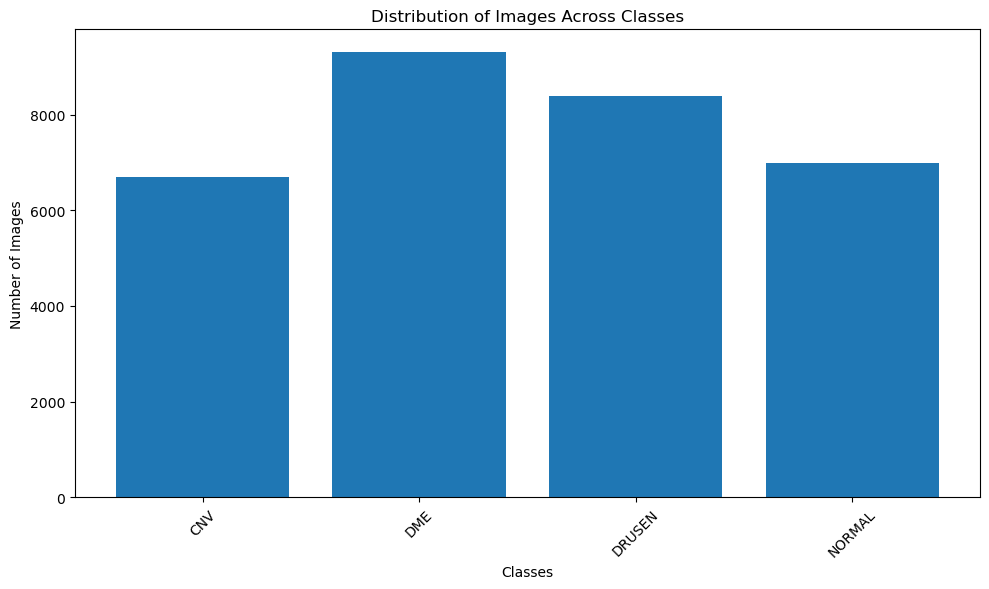

In [86]:
import matplotlib.pyplot as plt
import os


trainingdata_dir = imgdata_dir + "/train"

# Get the class names (assuming each subdirectory represents a class)
class_names = sorted(os.listdir(trainingdata_dir))

# Count the number of images in each class
class_counts = [len(os.listdir(os.path.join(trainingdata_dir, class_name))) for class_name in class_names]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The above bar plot shows the distribution of OCT images among different classes such as CNV, DME, DRUSEN, NORMAL. From the above bar graph we can say that DME has the highest number of OCT images

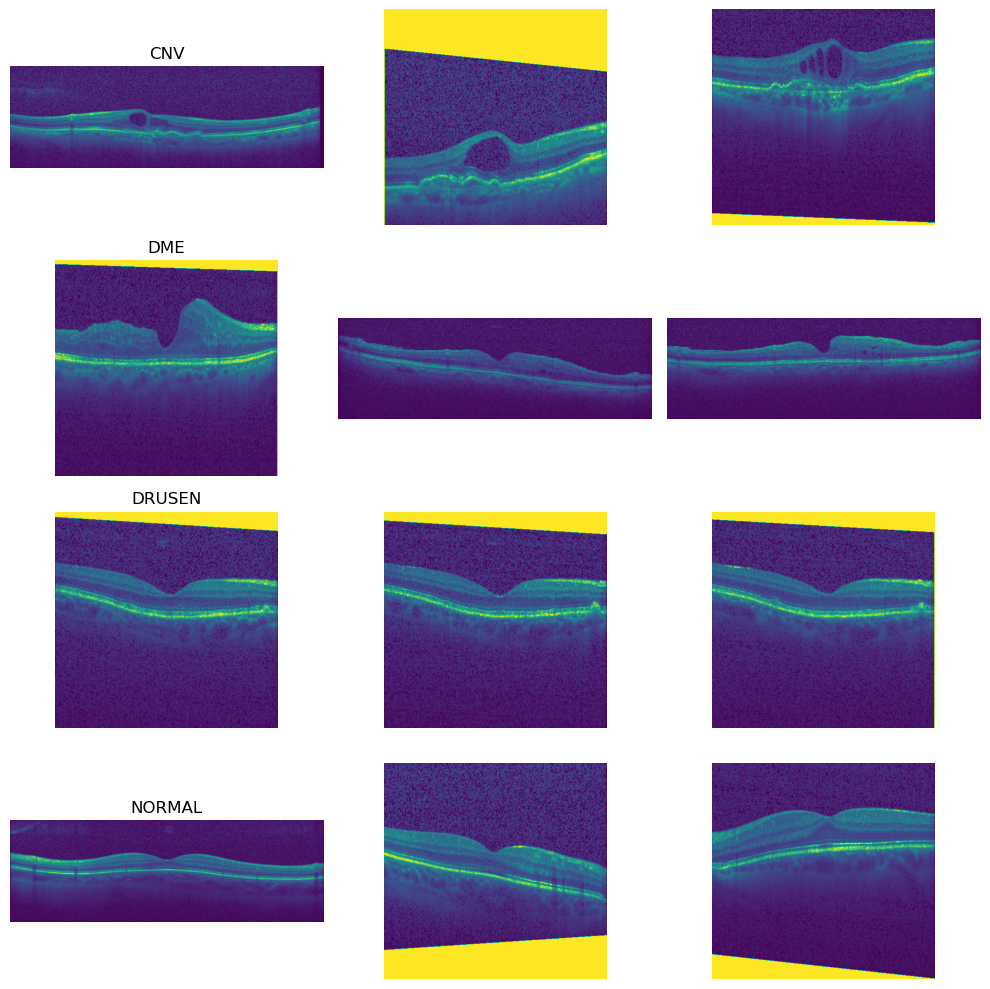

In [87]:
import matplotlib.pyplot as plt
import os
from PIL import Image


trainingdata_dir = imgdata_dir + "/train"

# Geting the class names (assuming each subdirectory represents a class)
class_names = sorted(os.listdir(trainingdata_dir))

# Number of sample images to display for each class
num_samples = 3

# Createing a figure for plotting images
fig, axes = plt.subplots(len(class_names), num_samples, figsize=(10, 10))

# Loop through each class and display sample images
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(trainingdata_dir, class_name)
    class_images = os.listdir(class_dir)[:num_samples]

    for j, image_filename in enumerate(class_images):
        image_path = os.path.join(class_dir, image_filename)
        image = Image.open(image_path)
        axes[i, j].imshow(image)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name)

plt.tight_layout()
plt.show()


In [88]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    trainingdata_dir,
    labels='inferred',
    seed=0,
    image_size=(128,128),
    batch_size=16,
    color_mode='rgb',
    validation_split= 0.2,
    subset='training'
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    trainingdata_dir,
    labels='inferred',
    seed=0,
    image_size=(128,128),
    batch_size=16,
    color_mode='rgb',
    validation_split=0.2,
    subset='validation'
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    testdata_dir,
    labels='inferred',
    image_size=(128,128),
    batch_size=16,
    color_mode='rgb',
)

Found 31392 files belonging to 4 classes.
Using 25114 files for training.
Found 31392 files belonging to 4 classes.
Using 6278 files for validation.
Found 993 files belonging to 4 classes.


In [89]:
class_labels= ['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [90]:
test_labels = [labels for _, labels in test.unbatch()]

# Data exploration

In [91]:
class_names=train.class_names
print(class_names)

['CNV', 'DME', 'DRUSEN', 'NORMAL']


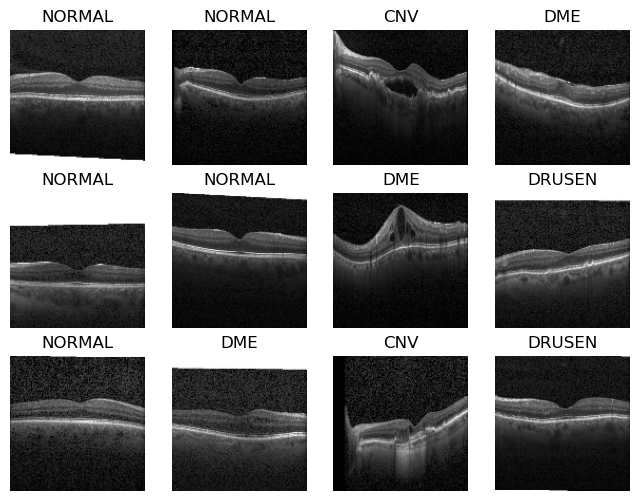

In [92]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
for images, labels in train.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Class distribution

In [93]:
BATCH_SIZE=16
class_names = train.class_names

def class_distribution(dataset):
    class_values = []
    total_batches = dataset.__len__().numpy()
    for batch, element in enumerate(dataset.as_numpy_iterator()):
        if batch+1 == total_batches:
            for i in range(len(element[1])):
                class_values.append(class_names[int(element[1][i])])
        else:
            for i in range(BATCH_SIZE):
                class_values.append(class_names[int(element[1][i])])

    class_n, frequency = np.unique(np.array(class_values), return_counts=True)
   
    return pd.DataFrame(frequency, class_n, columns=["Count"])

train_class_dist = class_distribution(train)
print(train_class_dist)

        Count
CNV      5323
DME      7536
DRUSEN   6705
NORMAL   5550


# Handling data imbalance

In [94]:
total = len(train.file_paths)
count_cnv = 5323
count_dme = 7536
count_drusen = 6705
count_normal = 5550
cnv_weight = (1/count_cnv) * (total/4)
dme_weight = (1/count_dme) * (total/4)
drusen_weight = (1/count_drusen) * (total/4)
norm_weight = (1/count_normal) * (total/4)
class_weight = {0 : cnv_weight, 1: dme_weight, 2 : drusen_weight, 3: norm_weight}
print(class_weight)

{0: 1.1795040390757092, 1: 0.8331342887473461, 2: 0.9363907531692767, 3: 1.1312612612612614}


# Pipeline

In [15]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train = (
    train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
validation = (
    validation
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
test = (
    test
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [16]:
model = tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',input_shape=(128,128,3)),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(units=4, activation='sigmoid'),
])

# Model training

In [17]:
optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.0001)


In [18]:
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights='True',
    min_delta=0.01)

history = model.fit(
    train,
    validation_data=validation,
    class_weight=class_weight,
    epochs= 10,
    shuffle=True,
)

Epoch 1/10
1570/1570 [==============================] - 1380s 878ms/step - loss: 0.6679 - accuracy: 0.3081 - val_loss: 1.5905 - val_accuracy: 0.3267
Epoch 2/10
1570/1570 [==============================] - 1340s 854ms/step - loss: 0.6335 - accuracy: 0.3534 - val_loss: 1.5132 - val_accuracy: 0.3527
Epoch 3/10
1570/1570 [==============================] - 1294s 824ms/step - loss: 0.6102 - accuracy: 0.3799 - val_loss: 1.4710 - val_accuracy: 0.3732
Epoch 4/10
1570/1570 [==============================] - 1307s 832ms/step - loss: 0.5900 - accuracy: 0.4056 - val_loss: 1.4347 - val_accuracy: 0.3953
Epoch 5/10
1570/1570 [==============================] - 980s 624ms/step - loss: 0.5710 - accuracy: 0.4303 - val_loss: 1.3986 - val_accuracy: 0.4086
Epoch 6/10
1570/1570 [==============================] - 811s 516ms/step - loss: 0.5521 - accuracy: 0.4559 - val_loss: 1.3611 - val_accuracy: 0.4337
Epoch 7/10
1570/1570 [==============================] - 813s 518ms/step - loss: 0.5334 - accuracy: 0.4832 - 

# Model performance

Best Validation Loss: 1.1757
Best Validation Accuracy: 0.5271


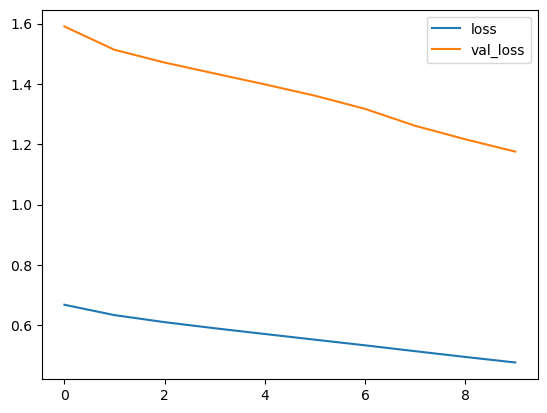

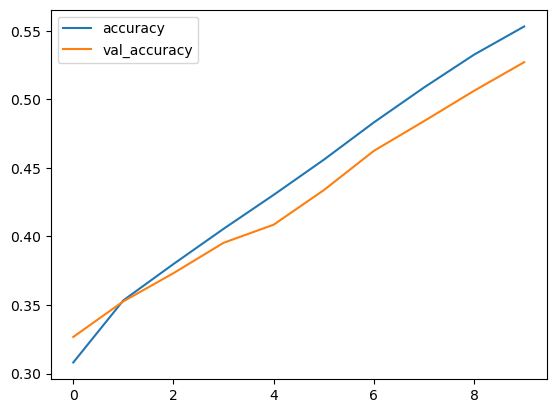

In [19]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

The output over here shows that the best Validation loss is 1.1757 and the best Validation accuracy is 0.5271

# Implementation of Batch Normalization and Dropout

In [20]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(renorm=True),
    layers.Dropout(0.3),
    layers.Dense(units=4, activation='sigmoid'),
])

In [21]:
optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.0001)

In [22]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights='True',
    min_delta=0.01)

history = model.fit(
    train,
    validation_data=validation,
    class_weight=class_weight,
    epochs= 20,
    callbacks=[early_stopping],
    shuffle=True,
)

Epoch 1/20
1570/1570 [==============================] - 839s 533ms/step - loss: 0.9785 - accuracy: 0.3288 - val_loss: 1.3276 - val_accuracy: 0.4207
Epoch 2/20
1570/1570 [==============================] - 735s 468ms/step - loss: 0.7640 - accuracy: 0.4263 - val_loss: 1.2024 - val_accuracy: 0.4855
Epoch 3/20
1570/1570 [==============================] - 1437s 915ms/step - loss: 0.6708 - accuracy: 0.4810 - val_loss: 1.1326 - val_accuracy: 0.5303
Epoch 4/20
1570/1570 [==============================] - 2776s 2s/step - loss: 0.6014 - accuracy: 0.5285 - val_loss: 1.0731 - val_accuracy: 0.5589
Epoch 5/20
1570/1570 [==============================] - 924s 589ms/step - loss: 0.5521 - accuracy: 0.5561 - val_loss: 1.0287 - val_accuracy: 0.5800
Epoch 6/20
1570/1570 [==============================] - 891s 568ms/step - loss: 0.5038 - accuracy: 0.5905 - val_loss: 0.9890 - val_accuracy: 0.5960
Epoch 7/20
1570/1570 [==============================] - 885s 564ms/step - loss: 0.4681 - accuracy: 0.6172 - val_l

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 128, 128, 3)      21        
 ormalization)                                                   
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       224       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                      

# Final performance

Best Validation Loss: 0.7196
Best Validation Accuracy: 0.7225


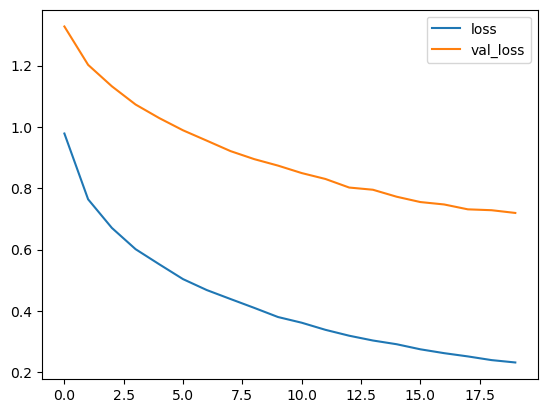

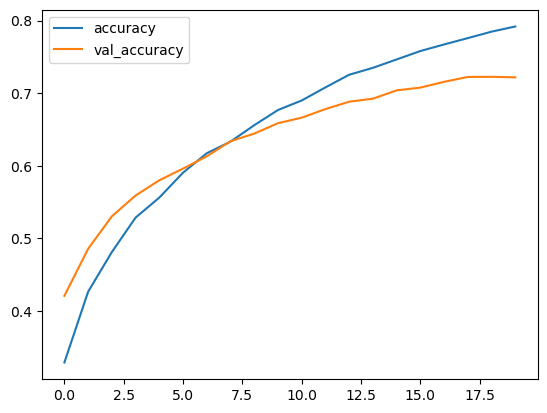

In [23]:
acc = history.history['accuracy']
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

# Model evaluation

In [24]:
model.evaluate(test, return_dict=True)

63/63 [==============================] - 6s 90ms/step - loss: 0.4291 - accuracy: 0.8359


{'loss': 0.42911797761917114, 'accuracy': 0.8358509540557861}

In [25]:
predictions = model.predict(test)
predictions = np.argmax(predictions, axis=1)

63/63 [==============================] - 6s 84ms/step


# Classification report

In [26]:
print(classification_report(predictions, test_labels, target_names=class_labels))

              precision    recall  f1-score   support

         CNV       0.17      0.20      0.18       202
         DME       0.29      0.28      0.28       273
      DRUSEN       0.32      0.23      0.27       349
      NORMAL       0.15      0.21      0.18       169

    accuracy                           0.23       993
   macro avg       0.23      0.23      0.23       993
weighted avg       0.25      0.23      0.24       993



Precision: Precision shows the proportion of true positive predictions among all positive predictions for a given class. This measure shows or indicates how accurate the model's positive predictions are for that class.

Recall: The proportion of true positive projections among all the actual positives for a class is known as Recall (also known as sensitivity or true positive rate). It indicates how accurately the model is able to correctly identify instances of that class.

F1-Score: It is the harmonic mean of precision and recall. It offers a balanced measure of a model's accuracy across precision and recall.

Support: Support shows the number of actual occurrences of each class in the test dataset.

Accuracy: Accuracy measures the proportion of correct predictions (both true positives and true negatives) among all predictions. It gives an overall measure of the model's correctness.

Macro Avg: The macro average first calculates the metrics such as precision, recall, F1-score for each class before averaging them. It treats all classes equally.

Weighted Avg: The weighted average calculates the metrics for each class and then the average is then weighted by the number of actual or true instances of each class. This gives more weight to classes with larger support.

# Confusion matrix

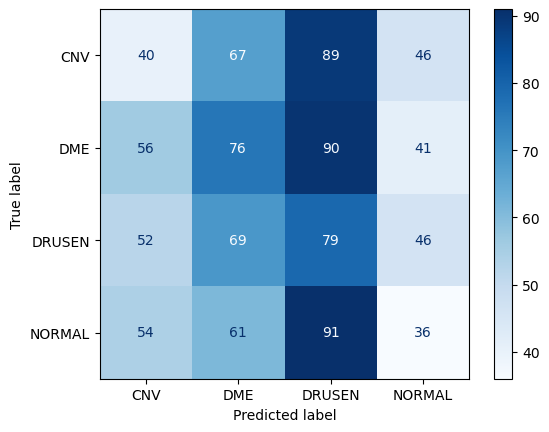

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

The code provided above generates a confusion matrix as shown. This matrix shows the performance of the model by showing the number of instances in the class. Each row shows the number of instances in the actual class whereas the columns show the number of instances in the predicted class.
The intensity of the blue color shows the number of images that fall into that particular category

# Prediction using test image

In [103]:
test_image_path = 'C:/test/CNV/CNV-53018-1.jpeg'  
img = image.load_img(test_image_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)


predictions = model.predict(img_array)
decoded_predictions = np.argmax(predictions, axis=1)

# Displaying the predicted class
print("Predicted class index:", decoded_predictions[0])


1/1 [==============================] - 0s 48ms/step
Predicted class index: 1


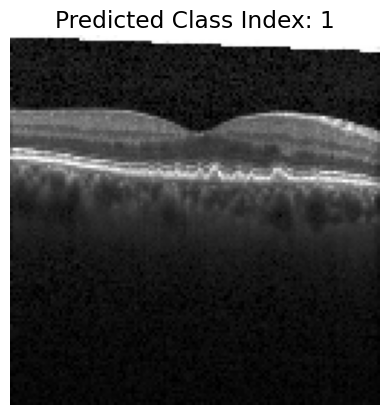

In [107]:
plt.imshow(image.array_to_img(img_array[0]))
plt.title("Predicted Class Index: " + str(decoded_predictions[0]))
plt.axis('off')
plt.show()